### Train AdBot
* The data provided contains the daily ad records for 185 clients from the Adbot platform. Each record contains information related to the ads including the cost, number of impressions, as well as the number of keywords used in the ads.

* The data provided also contains the calls clients receive as a result of hosting ads on the platform. These detail the daily number of received/missed calls as well as the duration of each call.

* The objective is to accurately predict the “clicks” a client’s ad receives, one and two weeks into the future. Winning solutions will further be required to submit a description of the variables that had the most significant impact on engagement (number of clicks). It is therefore important that the models you build are not only accurate but also interpretable.
* There are 1505 days for each adbot company. Meaning it's every single day for four years form 2020 - 2024
* Given that we have to forecast 7 days into the future how should we structure our train, val sets?
    * first of all each company shoould be treated separately and we should create a validation scheme that mimics this
        * each company train_val splits based on time
        * since we should forecast for 7 days and 14 days in future how should we build out training and val sets?
    * do we need all the days data?
    
Weekly sample
* use the actual weekly values and aggregated weekly stats values
* forecast then evaluate

* preds inside folds and average them

In [1]:
import pandas as pd
import numpy as  np
import seaborn as sns
import matplotlib.pyplot as plt

import catboost as catt
import lightgbm as lgb
import xgboost as xgb

from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

pd.options.display.max_columns = 500
import warnings
warnings.filterwarnings('ignore')


In [2]:
path= "/kaggle/input/adbot/"
train = pd.read_csv("/kaggle/input/adbot/Train.csv")
sub = pd.read_csv("/kaggle/input/adbot/SampleSubmission.csv")

display(train.head(), train.shape, sub.head(), sub.shape)

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
0,142.0,15.0,3393.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,5.0,11.0
1,89.0,8.0,1817.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0
2,59.0,8.0,1743.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,10.0
3,78.0,4.0,917.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,3.0,13.0
4,20.0,1.0,217.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0


(289926, 19)

,ID,clicks
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,0
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,0
2,ID_5e43c29e6279884e2827d894_2024_02_21,0
3,ID_5e43c29e6279884e2827d894_2024_02_28,0
4,ID_5e4e7b480e374330ee151305_2023_12_04,0


(370, 2)

In [3]:
train.isnull().sum() / len(train)

impressions           0.001380
clicks                0.001380
cost                  0.001380
conversions           0.001380
ad_type               0.001380
currency              0.001380
ID                    0.000000
date                  0.000000
call_type             0.872726
call_status           0.872726
start_time            0.872726
duration              0.872726
end_time              0.872726
display_location      0.872726
impression_share      0.000000
conversions_calls     0.033991
headline1_len         0.001380
headline2_len         0.001380
ad_description_len    0.001380
dtype: float64

In [4]:
def remove_nans(data, thresh):
    def nans_rate(data, col):
        return data[col].isna().sum() / data.shape[0]
    
    for col in data.columns:
        if nans_rate(data, col) >= thresh:
            data.drop(col, axis=1, inplace=True)
            
    return data

train = remove_nans(train, 0.7)
train.shape

(289926, 13)

In [5]:
train.apply(lambda x: x.nunique())

impressions            1600
clicks                  714
cost                  82548
conversions             238
ad_type                   3
currency                  2
ID                      185
date                   1505
impression_share      45199
conversions_calls         9
headline1_len             8
headline2_len             8
ad_description_len       21
dtype: int64

In [6]:
train.drop(columns = ['currency'], inplace=True)
train.sort_values(by = ['ID', 'date'], inplace=True)

In [7]:
print(train[train['ID'] == "ID_5da86e71bf5dee4cf5047046"]['date'].max(), train[train['ID'] == "ID_5da86e71bf5dee4cf5047046"]['date'].min())
sub[sub['ID'].str.contains("ID_5da86e71bf5dee4cf5047046")].head()


2024-01-14 2020-01-01


,ID,clicks
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,0
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,0


In [8]:
def get_date(value):
    parts = value.split('_')
    date = '_'.join(parts[2:])
    return date

def get_id(value):
    parts = value.split('_')
    id_ = '_'.join(parts[:2])
    return id_
def week_of_month(date_val):
    first_day = date_val.replace(day=1)
    day_of_month = date_val.day
    adjusted_dom = day_of_month + first_day.weekday()
    return int(np.ceil(adjusted_dom/7))


def build_datasets(train, sub, agent_id):
    min_date_sub_str = sub[sub['ID'].str.contains(agent_id)]['ID'].str.split('_').str[-3:].min()
    min_date_sub = pd.to_datetime('_'.join(min_date_sub_str), format='%Y_%m_%d')
    train_subset = train[train['ID'] == agent_id]
    max_date_train = pd.to_datetime(train_subset['date']).max()
    missing_dates = pd.date_range(start=max_date_train + pd.Timedelta(days=1), end=min_date_sub - pd.Timedelta(days=1), freq='D')
    missing_rows = pd.DataFrame({'date': missing_dates})
    missing_rows['ID'] = agent_id
    train_with_missing = pd.concat([train_subset, missing_rows], ignore_index=True)
    train_with_missing['identifier'] = 'train'
    sub['identifier'] = 'test'
    train_with_missing['date'] = pd.to_datetime(train_with_missing['date'])
    date_range = pd.date_range(start=train_with_missing['date'].min(), end=train_with_missing['date'].max())
    all_dates = pd.DataFrame(date_range, columns=['date'])
    all_dates['ID'] = train_with_missing['ID'].iloc[0]
    merged_df = pd.merge(all_dates, train_with_missing, on=['date', 'ID'], how='left')
    merged_df['identifier'] = merged_df['identifier'].fillna('train')
    merged_df['unique_id'] = merged_df['ID'].astype(str) + "_" + merged_df['date'].dt.strftime('%Y-%m-%d')
    sub_ =sub[sub['ID'].str.contains(agent_id)]
    sub_['date'] = sub_['ID'].apply(get_date)
    sub_['ID'] = sub_['ID'].apply(get_id)
    sub_['date'] = pd.to_datetime(sub_['date'], format='%Y_%m_%d')
    concatenated_df = pd.concat([merged_df, sub_], ignore_index=True)

    concatenated_df['date'] = pd.to_datetime(concatenated_df['date'])
    # Extract features:
    concatenated_df['day'] = concatenated_df['date'].dt.day  # Day of the month 
    concatenated_df['year'] = concatenated_df['date'].dt.year  # Day of the month 
    concatenated_df['week'] = concatenated_df['date'].dt.isocalendar().week  # Week of the year
    concatenated_df['month'] = concatenated_df['date'].dt.month  # Month of the year
    concatenated_df['is_weekend'] = concatenated_df['date'].dt.dayofweek >= 5  # True for Sat/Sun
    concatenated_df['day_of_week'] = concatenated_df['date'].dt.dayofweek
    concatenated_df['week_of_month'] = concatenated_df['date'].apply(week_of_month)
    concatenated_df['is_month_start'] = concatenated_df.date.dt.is_month_start.astype(int)
    concatenated_df['is_month_end'] = concatenated_df.date.dt.is_month_end.astype(int)
    concatenated_df['quarter_of_year'] = concatenated_df.date.dt.quarter
    concatenated_df['day_of_year'] = concatenated_df.date.dt.dayofyear
    
    
    # Aghgregate the data by date
    df_agg = concatenated_df.groupby('date').agg({
        'impressions': 'sum',
        'clicks': 'sum',
        'ad_type': 'first',  
        'ID': 'first',       
        'day': 'first',
        'year': 'first',
        'week': 'first',
        'month': 'first',
        'is_weekend': 'first',
        'week_of_month': 'first',
        'quarter_of_year': 'first',
        'day_of_year': 'first',
        'is_month_start': 'first',
        'is_month_end': 'first',
        'identifier': 'first'

    }).reset_index()

    # Group the DataFrame by week
    df_month = concatenated_df.groupby(['month']).agg({
        'impressions': ['mean', 'std', 'min', 'max', 'skew'],
        'cost': ['mean', 'std', 'min', 'max', 'skew'],

    }).reset_index()
    df_month.columns = ['month'] + [f"month_{col}_{stat}" for col, stat in df_month.columns[1:]]
    df_weekly = concatenated_df.groupby('week').agg({
        'impressions': ['mean', 'std', 'min', 'max', 'skew'],
        'cost': ['mean', 'std', 'min', 'max', 'skew'],

    }).reset_index()
    df_weekly.columns = ['week'] + [f"weekly_{col}_{stat}" for col, stat in df_weekly.columns[1:]]

    df_agg = pd.merge(df_agg, df_month, on='month', how='left')
    df_agg = pd.merge(df_agg, df_weekly, on='week', how='left')

    le_cols = ['ad_type']
    stats_cols = [col for col in df_agg.columns if any(substring in col for substring in ['mean', 'std', 'min', 'max', 'skew'])]

    lag_cols = [col for col in df_agg.columns if col not in stats_cols + ['date', 'ID','ad_type', 'unique_id', 'is_weekend', 'week_of_month', 'quarter_of_year', 'day_of_year',
       'is_month_start', 'is_month_end', 'day', 'year', 'week', 'month', 'identifier' ]]#and not any(suffix in col for suffix in ['mean', 'std', 'min', 'max', 'skew']
    date_cols = [ 'is_weekend', 'week_of_month', 'quarter_of_year', 'day_of_year',
           'is_month_start', 'is_month_end', 'day', 'year', 'week', 'month' ]
    for col in le_cols:
        df_agg[col] = le.fit_transform(df_agg[col])
        
    for col in lag_cols:
        for shift in range(15, 23):
            df_agg[f"lagged_{col}_{shift}"] = df_agg[col].shift(shift)

    for col in stats_cols:
        for shift in [15, 23, 30]:
            df_agg[f"lagged_{col}_{shift}"] = df_agg[col].shift(shift)
   

    for col in lag_cols:
        for shift in range(16, 23):
            lagged_col = f"lagged_{col}_{shift}"
            df_agg[f"diff_{col}_lagged_{shift}"] = df_agg[f"lagged_{col}_15"] - df_agg[lagged_col]

    for col in stats_cols:
        for shift in [23, 30]:
            lagged_col = f"lagged_{col}_{shift}"
            df_agg[f"diff_{col}_lagged_{shift}"] = df_agg[f"lagged_{col}_15"] - df_agg[lagged_col]

    independent_features =  [col for col in df_agg.columns if 'lagged' in col] + date_cols + [col for col in df_agg.columns if 'roll_mean' in col]
    df_agg = df_agg[['clicks', 'identifier', 'date', 'ID'] + independent_features + stats_cols]
    df_agg['unique_id'] = df_agg['ID'].astype(str) + "_" + df_agg['date'].dt.strftime('%Y-%m-%d')

    df_agg_train = df_agg[df_agg['identifier']=='train']

    n = len(df_agg_train)
    counter = 0
    selected_rows = []

    for i in range(n - 1, -1, -1):
        counter += 1
        if counter == 8 or counter == 15:
            selected_rows.append(df_agg_train.iloc[i])
        if counter == 15:
            counter = 0

    train_df = pd.DataFrame(selected_rows)
    test_df = df_agg[df_agg['identifier']=='test']
    return train_df, test_df


In [9]:
all_train_sets = []
all_test_sets = []
for agent_id in tqdm(train['ID'].unique()):
    train_set, test_set = build_datasets(train, sub, agent_id)
    all_train_sets.append(train_set)
    all_test_sets.append(test_set)
print(len(all_train_sets), len(all_test_sets))

100%|██████████| 185/185 [00:35<00:00,  5.23it/s]

185 185


In [10]:
final_train_df = pd.concat(all_train_sets)
final_test_df = pd.concat(all_test_sets)
final_train_df['ID'] = le.fit_transform(final_train_df['ID'])
final_test_df['ID'] = le.transform(final_test_df['ID'])
display(final_train_df.shape, final_train_df.head(), final_test_df.shape,final_test_df.head() )

(11119, 165)

,clicks,identifier,date,ID,lagged_impressions_15,lagged_impressions_16,lagged_impressions_17,lagged_impressions_18,lagged_impressions_19,lagged_impressions_20,lagged_impressions_21,lagged_impressions_22,lagged_clicks_15,lagged_clicks_16,lagged_clicks_17,lagged_clicks_18,lagged_clicks_19,lagged_clicks_20,lagged_clicks_21,lagged_clicks_22,lagged_month_impressions_mean_15,lagged_month_impressions_mean_23,lagged_month_impressions_mean_30,lagged_month_impressions_std_15,lagged_month_impressions_std_23,lagged_month_impressions_std_30,lagged_month_impressions_min_15,lagged_month_impressions_min_23,lagged_month_impressions_min_30,lagged_month_impressions_max_15,lagged_month_impressions_max_23,lagged_month_impressions_max_30,lagged_month_impressions_skew_15,lagged_month_impressions_skew_23,lagged_month_impressions_skew_30,lagged_month_cost_mean_15,lagged_month_cost_mean_23,lagged_month_cost_mean_30,lagged_month_cost_std_15,lagged_month_cost_std_23,lagged_month_cost_std_30,lagged_month_cost_min_15,lagged_month_cost_min_23,lagged_month_cost_min_30,lagged_month_cost_max_15,lagged_month_cost_max_23,lagged_month_cost_max_30,lagged_month_cost_skew_15,lagged_month_cost_skew_23,lagged_month_cost_skew_30,lagged_weekly_impressions_mean_15,lagged_weekly_impressions_mean_23,lagged_weekly_impressions_mean_30,lagged_weekly_impressions_std_15,lagged_weekly_impressions_std_23,lagged_weekly_impressions_std_30,lagged_weekly_impressions_min_15,lagged_weekly_impressions_min_23,lagged_weekly_impressions_min_30,lagged_weekly_impressions_max_15,lagged_weekly_impressions_max_23,lagged_weekly_impressions_max_30,lagged_weekly_impressions_skew_15,lagged_weekly_impressions_skew_23,lagged_weekly_impressions_skew_30,lagged_weekly_cost_mean_15,lagged_weekly_cost_mean_23,lagged_weekly_cost_mean_30,lagged_weekly_cost_std_15,lagged_weekly_cost_std_23,lagged_weekly_cost_std_30,lagged_weekly_cost_min_15,lagged_weekly_cost_min_23,lagged_weekly_cost_min_30,lagged_weekly_cost_max_15,lagged_weekly_cost_max_23,lagged_weekly_cost_max_30,lagged_weekly_cost_skew_15,lagged_weekly_cost_skew_23,lagged_weekly_cost_skew_30,diff_impressions_lagged_16,diff_impressions_lagged_17,diff_impressions_lagged_18,diff_impressions_lagged_19,diff_impressions_lagged_20,diff_impressions_lagged_21,diff_impressions_lagged_22,diff_clicks_lagged_16,diff_clicks_lagged_17,diff_clicks_lagged_18,diff_clicks_lagged_19,diff_clicks_lagged_20,diff_clicks_lagged_21,diff_clicks_lagged_22,diff_month_impressions_mean_lagged_23,diff_month_impressions_mean_lagged_30,diff_month_impressions_std_lagged_23,diff_month_impressions_std_lagged_30,diff_month_impressions_min_lagged_23,diff_month_impressions_min_lagged_30,diff_month_impressions_max_lagged_23,diff_month_impressions_max_lagged_30,diff_month_impressions_skew_lagged_23,diff_month_impressions_skew_lagged_30,diff_month_cost_mean_lagged_23,diff_month_cost_mean_lagged_30,diff_month_cost_std_lagged_23,diff_month_cost_std_lagged_30,diff_month_cost_min_lagged_23,diff_month_cost_min_lagged_30,diff_month_cost_max_lagged_23,diff_month_cost_max_lagged_30,diff_month_cost_skew_lagged_23,diff_month_cost_skew_lagged_30,diff_weekly_impressions_mean_lagged_23,diff_weekly_impressions_mean_lagged_30,diff_weekly_impressions_std_lagged_23,diff_weekly_impressions_std_lagged_30,diff_weekly_impressions_min_lagged_23,diff_weekly_impressions_min_lagged_30,diff_weekly_impressions_max_lagged_23,diff_weekly_impressions_max_lagged_30,diff_weekly_impressions_skew_lagged_23,diff_weekly_impressions_skew_lagged_30,diff_weekly_cost_mean_lagged_23,diff_weekly_cost_mean_lagged_30,diff_weekly_cost_std_lagged_23,diff_weekly_cost_std_lagged_30,diff_weekly_cost_min_lagged_23,diff_weekly_cost_min_lagged_30,diff_weekly_cost_max_lagged_23,diff_weekly_cost_max_lagged_30,diff_weekly_cost_skew_lagged_23,diff_weekly_cost_skew_lagged_30,is_weekend,week_of_month,quarter_of_year,day_of_year,is_month_start,is_month_end,day,year,week,month,month_impressions_mean,month_impressions_std,month_impressions_min,month_impr

(370, 165)

,clicks,identifier,date,ID,lagged_impressions_15,lagged_impressions_16,lagged_impressions_17,lagged_impressions_18,lagged_impressions_19,lagged_impressions_20,lagged_impressions_21,lagged_impressions_22,lagged_clicks_15,lagged_clicks_16,lagged_clicks_17,lagged_clicks_18,lagged_clicks_19,lagged_clicks_20,lagged_clicks_21,lagged_clicks_22,lagged_month_impressions_mean_15,lagged_month_impressions_mean_23,lagged_month_impressions_mean_30,lagged_month_impressions_std_15,lagged_month_impressions_std_23,lagged_month_impressions_std_30,lagged_month_impressions_min_15,lagged_month_impressions_min_23,lagged_month_impressions_min_30,lagged_month_impressions_max_15,lagged_month_impressions_max_23,lagged_month_impressions_max_30,lagged_month_impressions_skew_15,lagged_month_impressions_skew_23,lagged_month_impressions_skew_30,lagged_month_cost_mean_15,lagged_month_cost_mean_23,lagged_month_cost_mean_30,lagged_month_cost_std_15,lagged_month_cost_std_23,lagged_month_cost_std_30,lagged_month_cost_min_15,lagged_month_cost_min_23,lagged_month_cost_min_30,lagged_month_cost_max_15,lagged_month_cost_max_23,lagged_month_cost_max_30,lagged_month_cost_skew_15,lagged_month_cost_skew_23,lagged_month_cost_skew_30,lagged_weekly_impressions_mean_15,lagged_weekly_impressions_mean_23,lagged_weekly_impressions_mean_30,lagged_weekly_impressions_std_15,lagged_weekly_impressions_std_23,lagged_weekly_impressions_std_30,lagged_weekly_impressions_min_15,lagged_weekly_impressions_min_23,lagged_weekly_impressions_min_30,lagged_weekly_impressions_max_15,lagged_weekly_impressions_max_23,lagged_weekly_impressions_max_30,lagged_weekly_impressions_skew_15,lagged_weekly_impressions_skew_23,lagged_weekly_impressions_skew_30,lagged_weekly_cost_mean_15,lagged_weekly_cost_mean_23,lagged_weekly_cost_mean_30,lagged_weekly_cost_std_15,lagged_weekly_cost_std_23,lagged_weekly_cost_std_30,lagged_weekly_cost_min_15,lagged_weekly_cost_min_23,lagged_weekly_cost_min_30,lagged_weekly_cost_max_15,lagged_weekly_cost_max_23,lagged_weekly_cost_max_30,lagged_weekly_cost_skew_15,lagged_weekly_cost_skew_23,lagged_weekly_cost_skew_30,diff_impressions_lagged_16,diff_impressions_lagged_17,diff_impressions_lagged_18,diff_impressions_lagged_19,diff_impressions_lagged_20,diff_impressions_lagged_21,diff_impressions_lagged_22,diff_clicks_lagged_16,diff_clicks_lagged_17,diff_clicks_lagged_18,diff_clicks_lagged_19,diff_clicks_lagged_20,diff_clicks_lagged_21,diff_clicks_lagged_22,diff_month_impressions_mean_lagged_23,diff_month_impressions_mean_lagged_30,diff_month_impressions_std_lagged_23,diff_month_impressions_std_lagged_30,diff_month_impressions_min_lagged_23,diff_month_impressions_min_lagged_30,diff_month_impressions_max_lagged_23,diff_month_impressions_max_lagged_30,diff_month_impressions_skew_lagged_23,diff_month_impressions_skew_lagged_30,diff_month_cost_mean_lagged_23,diff_month_cost_mean_lagged_30,diff_month_cost_std_lagged_23,diff_month_cost_std_lagged_30,diff_month_cost_min_lagged_23,diff_month_cost_min_lagged_30,diff_month_cost_max_lagged_23,diff_month_cost_max_lagged_30,diff_month_cost_skew_lagged_23,diff_month_cost_skew_lagged_30,diff_weekly_impressions_mean_lagged_23,diff_weekly_impressions_mean_lagged_30,diff_weekly_impressions_std_lagged_23,diff_weekly_impressions_std_lagged_30,diff_weekly_impressions_min_lagged_23,diff_weekly_impressions_min_lagged_30,diff_weekly_impressions_max_lagged_23,diff_weekly_impressions_max_lagged_30,diff_weekly_impressions_skew_lagged_23,diff_weekly_impressions_skew_lagged_30,diff_weekly_cost_mean_lagged_23,diff_weekly_cost_mean_lagged_30,diff_weekly_cost_std_lagged_23,diff_weekly_cost_std_lagged_30,diff_weekly_cost_min_lagged_23,diff_weekly_cost_min_lagged_30,diff_weekly_cost_max_lagged_23,diff_weekly_cost_max_lagged_30,diff_weekly_cost_skew_lagged_23,diff_weekly_cost_skew_lagged_30,is_weekend,week_of_month,quarter_of_year,day_of_year,is_month_start,is_month_end,day,year,week,month,month_impressions_mean,month_impressions_std,month_impressions_min,month_impr

In [11]:
stats_cols = [col for col in final_train_df.columns if any(substring in col for substring in ['mean', 'std', 'min', 'max', 'skew'])]
date_cols = [ 'is_weekend', 'week_of_month', 'quarter_of_year', 'day_of_year',
       'is_month_start', 'is_month_end', 'day', 'year', 'week', 'month' ]
independent_features =  [col for col in final_train_df.columns if 'lagged' in col] + ['ID']+ date_cols + [col for col in stats_cols if 'lagged' not in col] + [col for col in final_train_df.columns if 'roll_mean' in col]

### Modelling

In [12]:
final_train_df = final_train_df.sort_values(by=['ID', 'date']).reset_index(drop=True)

In [13]:
from sklearn.model_selection import TimeSeriesSplit
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)


fold_preds = []
mse_scores = []
df = final_train_df.copy()
X = df[independent_features]
y = df['clicks']

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    model = catt.CatBoostRegressor(random_state=42, n_estimators = 500)
    model.fit(X_train, y_train, eval_set = (X_test, y_test), verbose = 1000)


    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred, squared=False)
    mse_scores.append(mse)
    
    print(f"rmse: {mse}")
    test_preds = model.predict(final_test_df[independent_features])
    fold_preds.append(test_preds)


avg_mse = np.mean(mse_scores)
print("Average RSE:", avg_mse)


Learning rate set to 0.088128
0:	learn: 27.2504490	test: 56.2890555	best: 56.2890555 (0)	total: 77.2ms	remaining: 38.5s
499:	learn: 3.0904727	test: 45.9985811	best: 45.8850697 (84)	total: 6.9s	remaining: 0us

bestTest = 45.88506971
bestIteration = 84

Shrink model to first 85 iterations.
rmse: 45.885069705010324
Learning rate set to 0.098246
0:	learn: 42.7984268	test: 132.9811842	best: 132.9811842 (0)	total: 25.9ms	remaining: 12.9s
499:	learn: 5.1948358	test: 112.7798445	best: 112.7404107 (180)	total: 8.78s	remaining: 0us

bestTest = 112.7404107
bestIteration = 180

Shrink model to first 181 iterations.
rmse: 112.74041068719696
Learning rate set to 0.104699
0:	learn: 81.2018822	test: 168.0535403	best: 168.0535403 (0)	total: 26.7ms	remaining: 13.3s
499:	learn: 7.5603478	test: 93.8560304	best: 93.8073401 (445)	total: 9.54s	remaining: 0us

bestTest = 93.80734007
bestIteration = 445

Shrink model to first 446 iterations.
rmse: 93.8073400656503
Learning rate set to 0.109534
0:	learn: 105.45

46.738683572199726 <br>
113.9517687 <br>
85.78990388 <br>
16.68310057 <br>
Average RSE: 65.79086417492064<br>




Text(0.5, 1.0, 'Lightgbm features importance (top 50):')

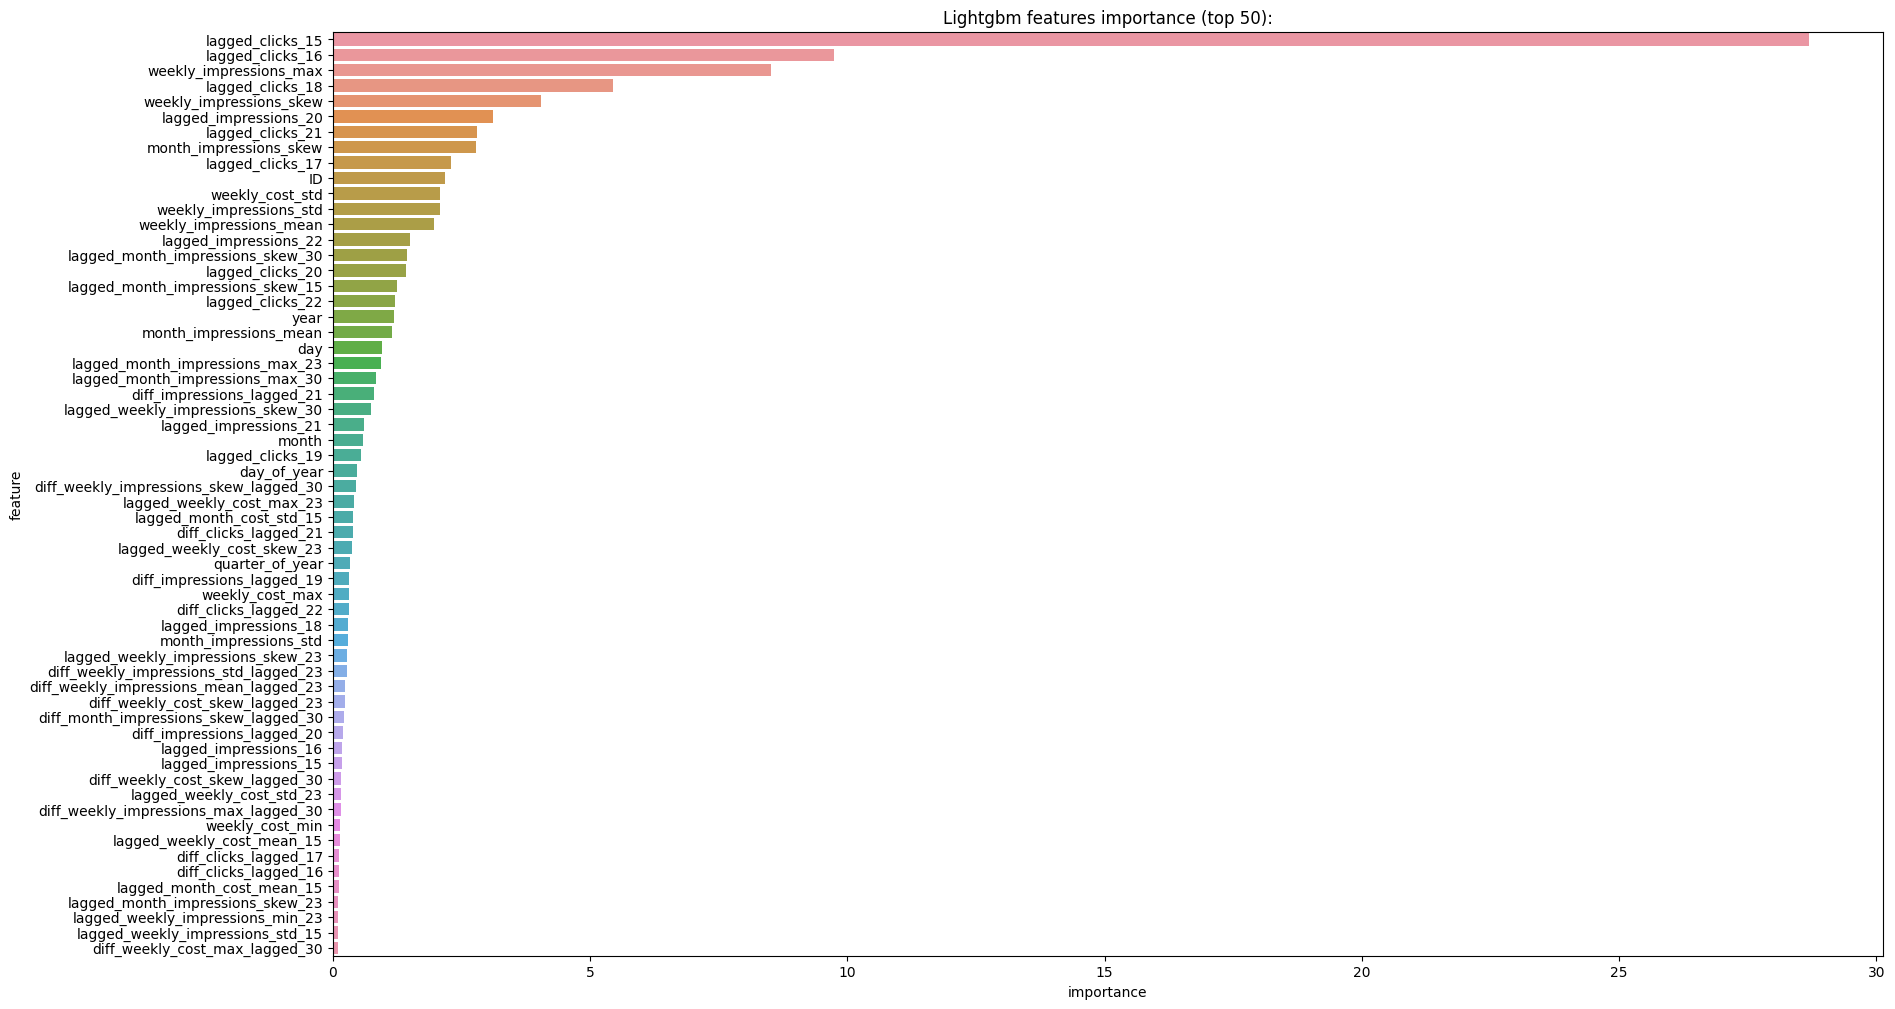

In [14]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('Lightgbm features importance (top 50):')

In [15]:
preds = np.mean(fold_preds, axis = 0)
final_test_df['preds'] = preds
sub = final_test_df[['unique_id', 'preds']]
sub['unique_id'] = sub['unique_id'].str.replace("-", "_")
sub.to_csv('12.27_sub.csv', index=False)


Full model inference
* This would be the one that I trust the most in these scenarios but I don't know why the above gave good results


In [17]:
model = catt.CatBoostRegressor(random_state = 42, n_estimators = 500)
model.fit(X, y, verbose = False)
test_preds = model.predict(final_test_df[independent_features])
final_test_df['preds'] = test_preds
sub = final_test_df[['unique_id', 'preds']]
sub['unique_id'] = sub['unique_id'].str.replace("-", "_")
sub.to_csv('full_model_sub.csv', index=False)